In [2]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import ndimage as ndi
from skimage import feature

# Data Import

In [3]:
filepath = os.path.abspath(os.path.join(os.getcwd(),'data'))
image_filepath = filepath + '/image_arrays.npy'
label_filepath = filepath + '/image_labels.npy'
binary_label_filepath = filepath + '/binary_image_labels.npy'

data_array = np.load(image_filepath, allow_pickle = True)
labels_array = np.load(label_filepath, allow_pickle = True)
binary_labels_array = np.load(binary_label_filepath, allow_pickle = True)

data = {'images':data_array,'labels':labels_array}
binary_data = {'images':data_array,'labels':binary_labels_array}

In [3]:
data['images'][0].shape

(208, 176)

# Examining Images

## Standard Image / Sharpened Image / Edge Detection

In [10]:
image = data['images'][100]
image_bgr = image

kernel = np.array([[0, -1, 0], 
                   [-1, 5,-1], 
                   [0, -1, 0]])

sharp_image = np.uint8(cv2.filter2D(image_bgr, -1, kernel))

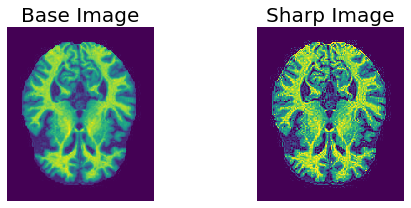

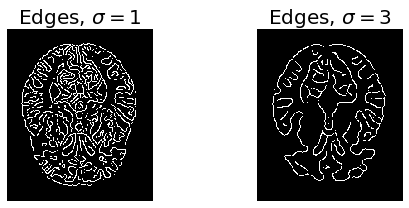

In [11]:
edges1 = feature.canny(image_bgr)
edges2 = feature.canny(image_bgr, sigma=3)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3),sharex=True, sharey=True)

ax1.imshow(image_bgr)
ax1.axis('off')
ax1.set_title('Base Image', fontsize=20)

ax2.imshow(sharp_image)
ax2.axis('off')
ax2.set_title('Sharp Image', fontsize=20)

fig2, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3),sharex=True, sharey=True)

ax3.imshow(edges1, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Edges, $\sigma=1$', fontsize=20)

ax4.imshow(edges2, cmap=plt.cm.gray)
ax4.axis('off')
ax4.set_title(r'Edges, $\sigma=3$', fontsize=20)

fig.tight_layout()
fig2.tight_layout()

plt.show()


## Visual Comparison of Demented vs. NonDemented

In [17]:
image_compare = {}
while len(image_compare) < 2:
    for i in range(0,len(data['images'])):
        if data['labels'][i] == 'ModerateDemented':
            image_compare['ModerateDemented'] = data['images'][i]
        elif data['labels'][i] == 'NonDemented':
            image_compare['NonDemented'] = data['images'][i]

Text(0.5, 1.0, 'ModerateDemented')

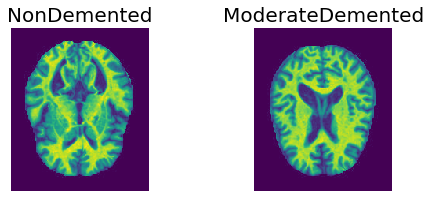

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3),sharex=True, sharey=True)

ax1.imshow(image_compare['NonDemented'])
ax1.axis('off')
ax1.set_title('NonDemented', fontsize=20)

ax2.imshow(image_compare['ModerateDemented'])
ax2.axis('off')
ax2.set_title('ModerateDemented', fontsize=20)

# Label Analysis

## Label Distribution

MildDemented -- Occurences: 896
ModerateDemented -- Occurences: 64
NonDemented -- Occurences: 3200
VeryMildDemented -- Occurences: 2240


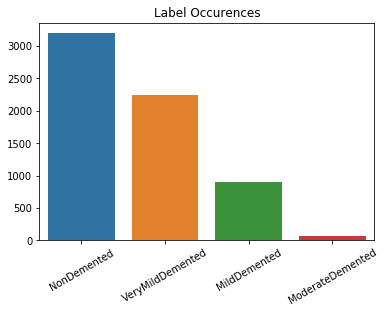

In [125]:
labels = {'NonDemented':0,'VeryMildDemented':0,'MildDemented':0,'ModerateDemented':0}
unique_labels, label_counts = np.unique(data['labels'], return_counts=True)

index = 0
for i in unique_labels:
    print(i,'-- Occurences:',label_counts[index])
    for k,v in labels.items():
        if k == i:
            labels[k] += int(label_counts[index])
    index += 1

ax = sns.barplot(x=list(labels.keys()), y=list(labels.values()))
ax.title.set_text('Label Occurences')
ax.set_xticklabels(labels = list(labels.keys()),rotation=30)
plt.show()

NonDemented -- Occurences: 3200
Demented -- Occurences: 3200


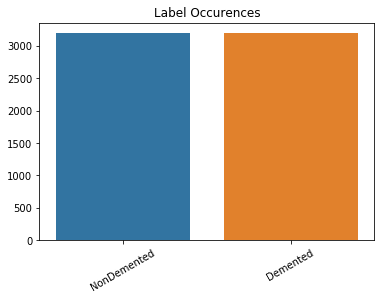

In [130]:
labels = {'NonDemented':0,'Demented':0}
unique_labels, label_counts = np.unique(binary_data['labels'], return_counts=True)

index = 0
for i in unique_labels:
    if i == 1:
        binary = 'Demented'
    else:
        binary = 'NonDemented'
    print(binary,'-- Occurences:',label_counts[index])
    for k,v in labels.items():
        if k == binary:
            labels[k] += int(label_counts[index])
    index += 1

ax = sns.barplot(x=list(labels.keys()), y=list(labels.values()))
ax.title.set_text('Label Occurences')
ax.set_xticklabels(labels = list(labels.keys()),rotation=30)
plt.show()

Based on the above two graphs, it is clear some sampling work will need to be done. There is a even split between NonDemented and Demented images, but stark differences between the count of stages of AD images, with a min of 64 and a max of 2240.

Due to the fact there are only 6,400 images total, it would not be prudent to trim the images down for better sampling. Instead, a synthetic sampling technique should be employed to make a more unbiased model.

In [137]:
data['images'].shape

(6400, 208, 176, 3)

In [136]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12, sampling_strategy = 1.0)
x_train_res, y_train_res = sm.fit_sample(data['images'], data['labels'])

ValueError: Found array with dim 4. Estimator expected <= 2.

# Keras Test

## Model

In [19]:
x_train[0].shape

NameError: name 'x_train' is not defined

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

def create_model(input_shape, n_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    return model


In [27]:
from keras.datasets import cifar10
from keras.utils import to_categorical

classes = 10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = to_categorical(y_train, classes)
y_test = to_categorical(y_test, classes)

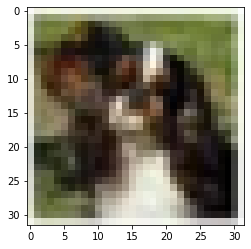

In [22]:
plt.imshow(x_train[500])

## Sharpener

In [28]:
def sharpen_images(images):
    sharpened_images = []
    for image in images:
        kernel = np.array([[0, -1, 0], 
                           [-1, 5,-1], 
                           [0, -1, 0]])

        sharp_image = np.uint8(cv2.filter2D(image, -1, kernel))
        sharpened_images.append(sharp_image)
    
    sharpened_images = np.array(sharpened_images)
    return sharpened_images

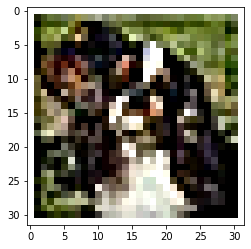

In [29]:
x_train_sharp = sharpen_images(x_train)
x_test_sharp = sharpen_images(x_test)

plt.imshow(x_train_sharp[500])

## Model1

In [30]:
x_train[0].shape

(32, 32, 3)

In [31]:
model1 = create_model(x_train[0].shape, 10)
batch_size = 256
epochs = 100
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1\
                     , validation_data=(x_test, y_test))

model1.evaluate(x_test, y_test)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 131s 3ms/step - loss: 2.4380 - accuracy: 0.1759 - val_loss: 1.7978 - val_accuracy: 0.3441
Epoch 2/100
 1280/50000 [..............................] - ETA: 2:14 - loss: 2.0216 - accuracy: 0.2703

KeyboardInterrupt: 

Text(0.5, 1.0, 'Accuracy Curves')

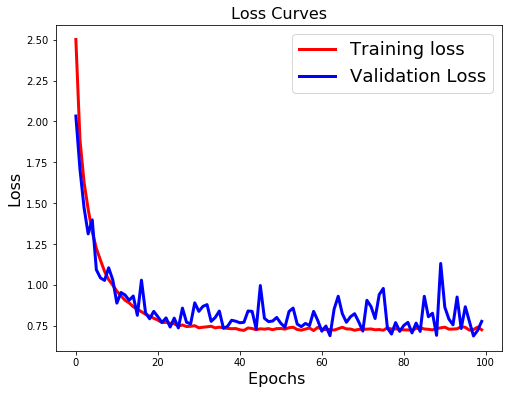

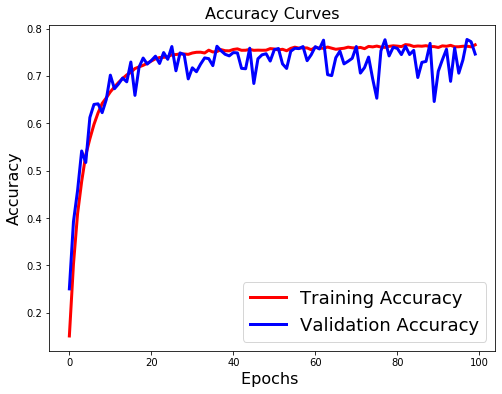

In [30]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

## Model2 (ImageDataGenerator)

In [36]:
from keras.preprocessing.image import ImageDataGenerator
ImageDataGenerator(
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.,
    zoom_range=.1,
    horizontal_flip=True,
    vertical_flip=True)

In [35]:
model2 = create_model(x_train[0].shape, 10)
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
batch_size = 256
epochs = 50
datagen = ImageDataGenerator(
        zoom_range=0.2, # randomly zoom into images
        rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        fill_mode='nearest')
# Fit the model on the batches generated by datagen.flow().
history2 = model2.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                              epochs=epochs,
                              validation_data=(x_test, y_test),
                              workers=4)
model2.evaluate(x_test, y_test)

Epoch 1/50
 32/196 [===>..........................] - ETA: 12s - loss: 3.5598 - accuracy: 0.1148

KeyboardInterrupt: 

Text(0.5, 1.0, 'Accuracy Curves')

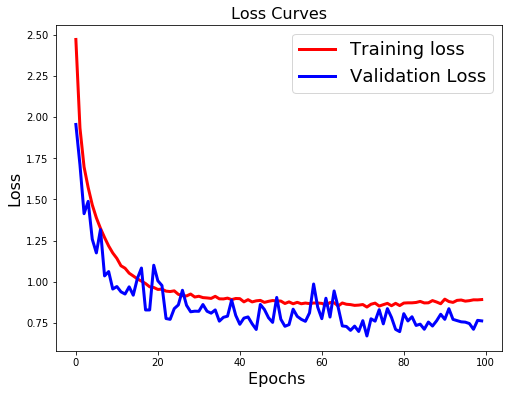

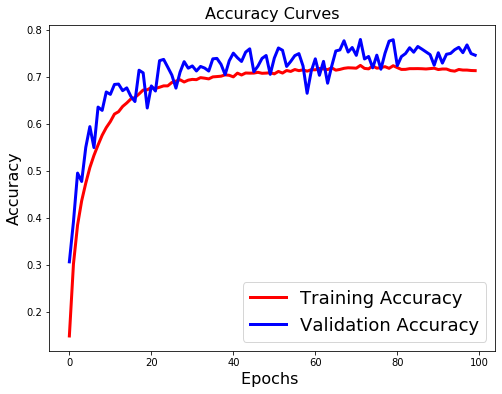

In [15]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history2.history['loss'],'r',linewidth=3.0)
plt.plot(history2.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history2.history['accuracy'],'r',linewidth=3.0)
plt.plot(history2.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

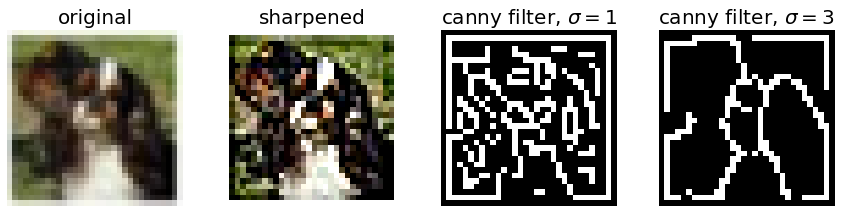

In [20]:
img = x_train[500]

kernel = np.array([[0, -1, 0], 
                   [-1, 5,-1], 
                   [0, -1, 0]])

image_sharp = cv2.filter2D(img, -1, kernel)
image_sharp = np.uint8(image_sharp)
edges = cv2.Canny(img,50,50)


edges1 = feature.canny(image_sharp[:,:,0])
edges2 = feature.canny(image_sharp[:,:,0], sigma=3)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(12, 4),sharex=True, sharey=True)

ax0.imshow(img, cmap=plt.cm.gray)
ax0.axis('off')
ax0.set_title('original', fontsize=20)

ax1.imshow(image_sharp, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('sharpened', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

## Model v2

In [37]:
def create_model2(input_shape, n_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [43]:
model3 = create_model(x_train[0].shape, 10)
model3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
batch_size = 256
epochs = 200
datagen = ImageDataGenerator(
        #zoom_range=0.2, # randomly zoom into images
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        fill_mode='nearest')
# Fit the model on the batches generated by datagen.flow().
history3 = model3.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                              epochs=epochs,
                              validation_data=(x_test, y_test),
                              workers=4)
model3.evaluate(x_test, y_test)

Epoch 1/200
196/196 [==============================] - 15s 75ms/step - loss: 2.4245 - accuracy: 0.1741 - val_loss: 1.8060 - val_accuracy: 0.3498
Epoch 2/200
196/196 [==============================] - 14s 73ms/step - loss: 1.9250 - accuracy: 0.2954 - val_loss: 1.6864 - val_accuracy: 0.3846
Epoch 3/200
196/196 [==============================] - 14s 72ms/step - loss: 1.7518 - accuracy: 0.3601 - val_loss: 1.6532 - val_accuracy: 0.4100
Epoch 4/200
196/196 [==============================] - 14s 70ms/step - loss: 1.6494 - accuracy: 0.4006 - val_loss: 1.3562 - val_accuracy: 0.5120
Epoch 5/200
196/196 [==============================] - 15s 75ms/step - loss: 1.5699 - accuracy: 0.4360 - val_loss: 1.2695 - val_accuracy: 0.5581
Epoch 6/200
196/196 [==============================] - 14s 74ms/step - loss: 1.5086 - accuracy: 0.4620 - val_loss: 1.2438 - val_accuracy: 0.5474
Epoch 7/200
196/196 [==============================] - 14s 72ms/step - loss: 1.4527 - accuracy: 0.4805 - val_loss: 1.2293 - val_ac

196/196 [==============================] - 14s 69ms/step - loss: 1.0753 - accuracy: 0.6526 - val_loss: 0.8397 - val_accuracy: 0.7169
Epoch 114/200
196/196 [==============================] - 14s 70ms/step - loss: 1.0655 - accuracy: 0.6547 - val_loss: 0.8703 - val_accuracy: 0.7014
Epoch 115/200
196/196 [==============================] - 14s 72ms/step - loss: 1.0774 - accuracy: 0.6504 - val_loss: 0.9010 - val_accuracy: 0.6910
Epoch 116/200
196/196 [==============================] - 14s 70ms/step - loss: 1.0634 - accuracy: 0.6572 - val_loss: 0.9026 - val_accuracy: 0.6977
Epoch 117/200
196/196 [==============================] - 14s 72ms/step - loss: 1.0495 - accuracy: 0.6577 - val_loss: 0.9307 - val_accuracy: 0.6741
Epoch 118/200
196/196 [==============================] - 14s 71ms/step - loss: 1.0731 - accuracy: 0.6550 - val_loss: 0.9606 - val_accuracy: 0.6709
Epoch 119/200
196/196 [==============================] - 14s 71ms/step - loss: 1.0750 - accuracy: 0.6525 - val_loss: 0.9081 - val_ac

Epoch 169/200
196/196 [==============================] - 14s 69ms/step - loss: 1.1539 - accuracy: 0.6325 - val_loss: 0.9400 - val_accuracy: 0.6828
Epoch 170/200
196/196 [==============================] - 13s 68ms/step - loss: 1.1220 - accuracy: 0.6340 - val_loss: 0.8991 - val_accuracy: 0.6937
Epoch 171/200
196/196 [==============================] - 14s 71ms/step - loss: 1.1628 - accuracy: 0.6252 - val_loss: 0.9613 - val_accuracy: 0.6854
Epoch 172/200
196/196 [==============================] - 14s 71ms/step - loss: 1.1379 - accuracy: 0.6314 - val_loss: 1.1364 - val_accuracy: 0.6603
Epoch 173/200
196/196 [==============================] - 14s 70ms/step - loss: 1.1366 - accuracy: 0.6337 - val_loss: 0.9903 - val_accuracy: 0.6783
Epoch 174/200
196/196 [==============================] - 14s 69ms/step - loss: 1.1717 - accuracy: 0.6251 - val_loss: 0.8743 - val_accuracy: 0.6999
Epoch 175/200
196/196 [==============================] - 13s 68ms/step - loss: 1.1544 - accuracy: 0.6280 - val_loss: 1

[1.1388349136352538, 0.6177999973297119]

Text(0.5, 1.0, 'Accuracy Curves')

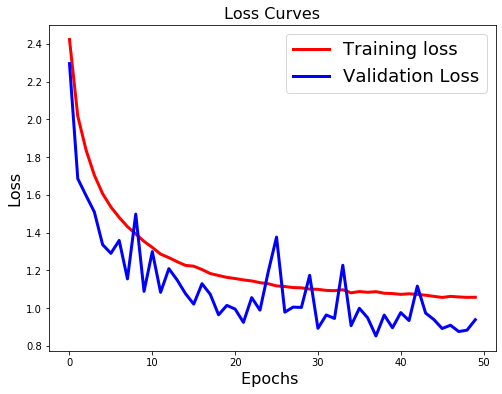

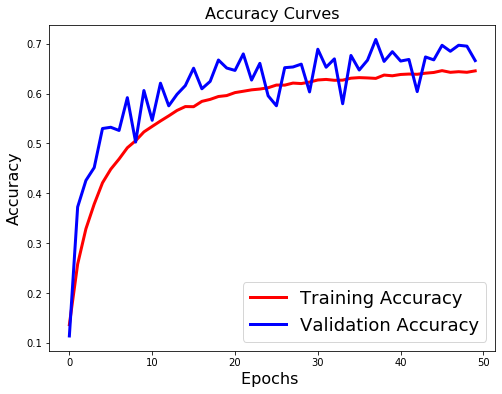

In [42]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history3.history['loss'],'r',linewidth=3.0)
plt.plot(history3.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history3.history['accuracy'],'r',linewidth=3.0)
plt.plot(history3.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [138]:
test_im_fp = 'C:/Users/sourp/Pictures/Vivaldi Captures/frobbit.jpg'
test_im = cv2.imread(test_im_fp)

(384, 351, 3)

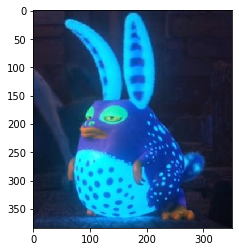

In [140]:
plt.imshow(test_im)
test_im.shape

In [4]:
from oversampler import oversampler
o = oversampler(x=data['images'], y=data['labels'], oversample_ratio=.5)


In [4]:
labs, counts = o.get_oversample_count()

In [7]:
counts

{'NonDemented': 0,
 'MildDemented': 1152,
 'ModerateDemented': 1568,
 'VeryMildDemented': 480}

In [8]:
neighbors = o._get_knn(labs['ModerateDemented'][0], labs['ModerateDemented'])

In [9]:
artificial_image = np.mean(neighbors, axis=0)

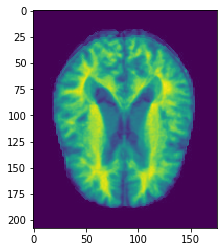

In [10]:
plt.imshow(artificial_image)

In [5]:
artificial_images = o.smote()

MildDemented 896
ModerateDemented 64
VeryMildDemented 2240


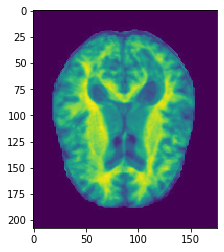

In [16]:
plt.imshow(artificial_images['MildDemented'][100])